# Bank Scoring Project final Notebook
This work project was elaborated by
- Ala Mani
- Brahim Driss
- Ibrahim Ben Abdallah
- Marouene Dakhlaoui 
- Mohamed Amine Hamza
- Raed ben cherif
- Oussama Sassi

Using 3 different bank datasets (Taiwan ,Usa, Germany) , our goal was to end up with an accurate scoring system by clustering and classifiying clients in order to help optimize the decision making process when it comes to handing out loans .

Since it's better for a bank to classify a good client as bad than classify a bad client as good , we choose as our evaluation metric the Precision Score of the models .
In this NoteBook , we selected for each bank the best model along with some snippets of the data preprocessing and modeling .

## Importing our dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score,precision_score
import xgboost as xgb
import catboost as cb

from DS2Pipe.Prepro import Prepro as Pp

import matplotlib.pyplot as plt
%matplotlib inline

# German Credit Dataset

### Data preprocessing

In [2]:
german = pd.read_table("german.data", delimiter=' ', header=None)
german.columns = ['Status_Account', 'Duration', 'Credit_History', 'Purpose', 'Credit_Amount',
                     'Saving_Account', 'Present', 'Installment', 'Personal_Status', 'Other', 
                         'Residence', 'Property', 'Age', 'Other_Installment', 'Housing', 'Existing_Credits',
                             'Job', 'Liable_People', 'Tel', 'Foreign_Worker', 'Actual_Score']
target = german.iloc[:,-1]   # Enregistrer la varialbe target
germanOrigin = german
german = german.iloc[:,0:-1]; # Enleveer la colonne target
german = german.drop(columns="Tel") # Enlever la colonne tel
germanV2 = germanOrigin
Pipe = Pp(german,target)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [3]:
def ScaleMinMax(data_num):
    scaler = MinMaxScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    return data_num_sc

def ScalerStandard(data_num):
    scaler = StandardScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    return data_num_sc

def KMENAS(data):
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(data);
    #print(metrics.silhouette_score(np.reshape(list(target), (1000,-1)),kmeans.labels_))
    plt.figure('K-means with 2 clusters', figsize=(15,10))
    plt.scatter(germanOrigin['Duration'], germanOrigin['Credit_Amount'], c=kmeans.labels_)
    plt.show()
    return pd.crosstab(target,kmeans.labels_)

def CAH(data):
    matrice = linkage(data,method='ward', metric='euclidean')
    plt.figure(figsize=(20,20))
    plt.title('Dendogramme')
    dendrogram(matrice)
    plt.show()
    return matrice

### __Clustering__ 

We run almost every combination of Dimension reduction algorithms ( SVD / PCA / KPCA ) and Data rescaling methods to finally keep the best segmentation obtained , minimising the "Bad clients predicted good" ratio .

#### KMEANS + StandardScaler 

In [4]:
data_cat = germanV2.select_dtypes(include=['object'])
data_cat_og = germanV2.select_dtypes(include=['object'])
data_num_og = germanV2._get_numeric_data()
data_num = germanV2._get_numeric_data()

dataCatOrd = data_num[data_num.columns[~data_num.columns.isin(['Duration','Credit_Amount', 'Age'])]]
data_num.drop(dataCatOrd.columns, axis=1, inplace=True)

for col in data_cat:
    onehot = pd.get_dummies(data_cat[col])
    data_cat = data_cat.drop(col,axis = 1)
    data_cat = data_cat.join(onehot)

data_cat = pd.concat([data_cat,dataCatOrd],axis=1)

cols = []
qmn = data_num['Credit_Amount'].quantile(q=0.25)
qmx = data_num['Credit_Amount'].quantile(q=0.75)
data_num['Credit_Amount'] = data_num['Credit_Amount'].apply(lambda x : qmn if x < qmn else (qmx if x > qmx else x))

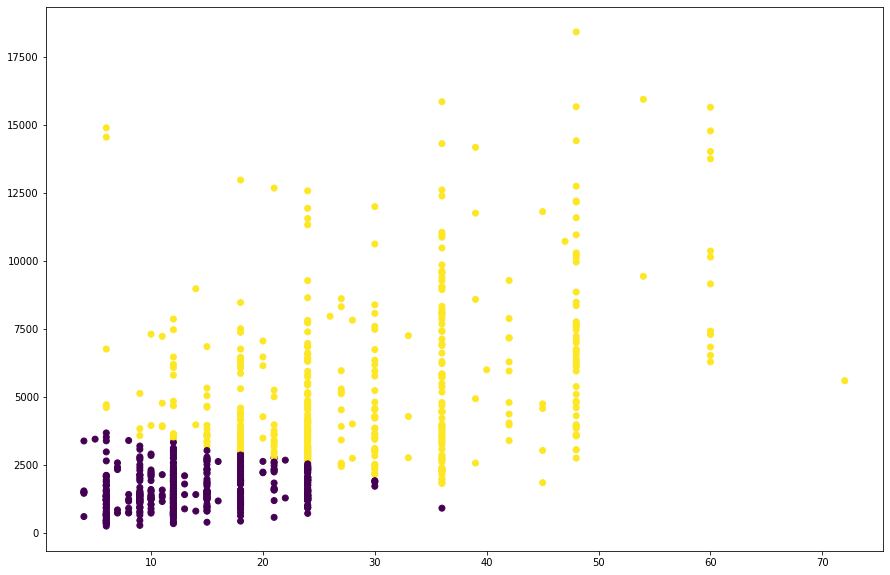

col_0,0,1
Actual_Score,,
1,426,274
2,148,152


In [5]:
data_num_red = ScalerStandard(data_num)
reduced_data = PCA(n_components=2).fit_transform(data_num_red)

KMENAS(pd.DataFrame(data_num_red))

### __Classification__ 

#### Feature Engineering 

After some exploratory data analysis , variables correlation with the target study (Chi2, Kendall , Anova ) and feature selection , we decided to drop some columns that gives no relevant information about our target variable .

We OneHotEncoded the remaining categorical variables , and scaled using Sickit-learn StandardScaler ( Gave us better results than other scalers ) before Train Test splitting and running the final joined data to our Models pipelines .

PCA was irrelevant in our case since it explained 80% with more than 30 column .

In [6]:
data2 = germanV2.drop(columns=["Liable_People","Residence","Purpose","Job","Existing_Credits","Tel","Other","Installment","Personal_Status"])
Pipe2 = Pp(data2,target)
Pipe2.data_split([1,3,7],[1,3,7])
ger_cat = Pipe2.quali
dictEnc = {}
var_categs = []
for col in ger_cat.columns:
    le = LabelEncoder()
    varLE = le.fit_transform(ger_cat[col])
    dictEnc[col] = le
    var_categs.append(pd.DataFrame(varLE))
data_cat_LE = pd.concat(var_categs, axis=1)
ohe = OneHotEncoder()
data_cat_OH = ohe.fit_transform(data_cat_LE)
dictEnc['onehot'] = ohe
j = pd.DataFrame(data_cat_OH.toarray())

data7 = Pipe2.data_join(Pipe.scaler(Pipe2.num,1),j)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data7, target-1, test_size = 0.25, random_state = 0)

### XGBoost Classifier 

We used BayesianOptimization for XGBoost to select optimal values for some of our XGboost Classifier .
Our target as explained above was Precision so the eval metric was precision score .
Other models like KNN , Random Forest , LGBM (non optimised ) gave around ~70%-78% 
So we kept this one .

In [8]:
classifier2 = XGBClassifier(gamma=0.9, 
                            learning_rate= 0.2, 
                            max_depth= 6, 
                            n_estimators= 172,
                            subsample = 0.8,
                            eta = 0.1,
                            eval_metric = 'rmse').fit(X_train, y_train)

#predicting for training set
train_p2 = classifier2.predict(X_test)

#Looking at the classification report
print(classification_report(train_p2, y_test))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       192
           1       0.42      0.53      0.47        58

    accuracy                           0.72       250
   macro avg       0.63      0.66      0.64       250
weighted avg       0.75      0.72      0.73       250



# America Credit Dataset 

In [9]:
americaOrigin = pd.read_csv('usa.csv')
target = americaOrigin['BAD']
america_cat_or = americaOrigin.iloc[:,[7,8,10,4,5]]


#### In this part, we have splitted the numeric and categorical data 
- We logged the Label Encoder dictionnary of each categorical feature and the Dictionnary of the OneHotEncoder in order to use them for the new registered clients to predict them using the Models we generated so that we obtain maximum accuracy.
- to deal with missing valeus of the discrete variables, we proceeded with interpolating these variables to predict them.
- And for the missing categoricals values, the best method is to fill them with the most frequent modality for each feature.
- We capped/floored the outliers after detecting them with Tukey's method using the first and third quantile

In [10]:
def QualiQuantiDecomposition(data):
    data_cat = data.select_dtypes(include=['object'])
    data_num = data._get_numeric_data()
    dictEnc = {}
    var_categs = []
    
    data_cat_imputed = data_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
    
    for col in data_cat.columns:
        le = LabelEncoder()
        varLE = le.fit_transform(data_cat_imputed[col])
        dictEnc[col] = le
        var_categs.append(pd.DataFrame(varLE))
    
    data_cat_LE = pd.concat(var_categs, axis=1)
    ohe = OneHotEncoder()
    data_cat_OH = ohe.fit_transform(data_cat_LE)
    dictEnc['onehot'] = ohe
        
    
    data_discrete = data_num[['DEROG', 'DELINQ', 'NINQ']]
    
    data_discrete_interpolated = data_discrete.interpolate()
    
    data_cat = pd.concat([data_discrete_interpolated, pd.DataFrame(data_cat_OH.toarray())], axis=1)
    
    data_num.drop(['DEROG', 'DELINQ', 'NINQ'], axis=1, inplace = True)    
        
    for col in data_num: 
        cols = []
        qmn = data_num[col].quantile(q=0.25)
        qmx = data_num[col].quantile(q=0.75)
        data_num[col] = data_num[col].apply(lambda x : qmn if x < qmn else (qmx if x > qmx else x))
        
    return data_num, data_cat, dictEnc

def fillNAN(data, method):
    if method == "mean":
        return data.fillna(data.mean())
    elif method == "median":
        return data.fillna(data.median())
    else:
        return "error"

### Clustering 

#### Applyinh the Kmeans Algorithm after Scaling the Numeric Data with Standard Scaler and reducing the dimensions with KernellPCA method and filling the missing values with the median Value have shown the best Segmentation of our data.
#### We can see that the model have detected all the Bad clients which is the best scenario in our case

In [11]:
data_num_am = americaOrigin._get_numeric_data()
scaler = StandardScaler()
data_num_sc = pd.DataFrame(scaler.fit_transform(data_num_am), columns=data_num_am.columns)

kpca = KernelPCA(n_components=2,kernel="rbf")
reduced_data_kpca = kpca.fit_transform(data_num_sc)
kmeans = KMeans(n_clusters=2,random_state=0)
kmeans.fit(pd.DataFrame(reduced_data_kpca))
pd.crosstab(target,kmeans.labels_)

col_0,0,1
BAD,,
0,1805,2966
1,1089,0


### Classification XGBoost 

### Before applying the Classification algorithms we need to deal with the missing values of the continious features.
- filling them with the median value of each feature or with the mean values have gave us the same performances so we proceeded with the median

In [12]:
america_num, america_cat, dict_Enc = QualiQuantiDecomposition(americaOrigin.drop(['BAD', 'CLNO', 'JOB'], axis=1))
america_num_or = america_num
america_num = fillNAN(america_num_or, "median")

america_numstandard = ScalerStandard(america_num)
america_joined_standard = pd.concat([america_numstandard, america_cat], axis=1)

X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(america_joined_standard, target)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


- We run a Grid Search on the XGBoost Classifier in order to retrieve the best Hyper parameters for The XGB Classifier for the sake of giving the best possible results and Accuracy to our model.
- The parameters put below have gave us 90% Accuracy

In [13]:
classifier2 = xgb.XGBClassifier(colsample_bytree = 0.5,
                             eta = 0.05,
                             gamma = 0.4,
                             max_depth = 10,
                             min_child_weight = 1).fit(X_train_st, y_train_st)

yPredGrid_st = classifier2.predict(X_test_st)
print(classification_report(y_test_st, yPredGrid_st))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1192
           1       0.83      0.56      0.67       273

    accuracy                           0.90      1465
   macro avg       0.87      0.77      0.81      1465
weighted avg       0.89      0.90      0.89      1465



# Bank of Taiwan 

In [14]:
data = pd.read_excel(r"default of credit card clients.xls",skiprows=1,index_col=0)
target_t = data.iloc[:,-1]

In [15]:
def replaceModalitites(data, racine, cible):
    return data.replace(to_replace=racine, value=cible)

In [16]:
taiwan_num = data[['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
taiwan_num_sc = ScalerStandard(taiwan_num)

### Clustering 

In [17]:
# kpca = KernelPCA(n_components=2,kernel="rbf")
# # america_numstandard.drop(['DEROG','DELINQ','NINQ','MORTDUE'], axis=1, inplace=True)
# reduced_data_kpca_t = kpca.fit_transform(taiwan_num_sc)
# kmeans = KMeans(n_clusters=2,random_state=0)
# kmeans.fit(pd.DataFrame(reduced_data_kpca_t))
# pd.crosstab(target_t,kmeans.labels_)

In [18]:
#Education
education=data["EDUCATION"]
education=pd.DataFrame(education)
education=replaceModalitites(education,[0,5,6],[4,4,4])

#Mariage
marriage=data["MARRIAGE"]
marriage=pd.DataFrame(marriage)
marriage=replaceModalitites(marriage,[0],[3])

data["EDUCATION"]=education
data["MARRIAGE"]=marriage

data.drop(columns=["LIMIT_BAL","PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6","SEX","MARRIAGE"],inplace=True)

fil = (data.PAY_0 == -1) | (data.PAY_0==-2)
data.PAY_0.value_counts()
fil = (data.PAY_2 == -1) | (data.PAY_2==-2)
data.loc[fil,'PAY_2']=0
fil = (data.PAY_3 == -1) | (data.PAY_3==-2)
data.loc[fil,'PAY_3']=0
fil = (data.PAY_4 == -1) | (data.PAY_4==-2)
data.loc[fil,'PAY_4']=0
fil = (data.PAY_5 == -1) | (data.PAY_5==-2)
data.loc[fil,'PAY_5']=0
fil = (data.PAY_6 == -1) | (data.PAY_6==-2)
data.loc[fil,'PAY_6']=0

### Classification 

In [19]:
def Catboost():    
    catt = cb.CatBoostClassifier(eval_metric='Accuracy',use_best_model=True,random_seed=0,silent=True)
    catt_model=catt.fit(X_train, y_train,eval_set=(X_test,y_test))
    y_pred_catt = catt_model.predict(X_test)
    print(classification_report(y_test,y_pred_catt)) 


In [20]:
Models_results=Catboost();

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       176
           1       0.66      0.39      0.49        74

    accuracy                           0.76       250
   macro avg       0.72      0.65      0.67       250
weighted avg       0.75      0.76      0.74       250

